# Imports

In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Data structure

In [13]:
def print_structure(name, obj):
    """Callback function to print the structure of the HDF5 file."""
    print(name)
    if isinstance(obj, h5py.Group):
        print("  [Group]")
    elif isinstance(obj, h5py.Dataset):
        print(f"  [Dataset] Shape: {obj.shape}, Data Type: {obj.dtype}")
        
        
file_name = 'OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t174138.he5'
file_path = f"OMTO3d/{file_name}"

# Code to print the file structure
try:
    with h5py.File(file_path, "r") as file:
        print("HDF5 File Structure:")
        file.visititems(print_structure)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

HDF5 File Structure:
HDFEOS
  [Group]
HDFEOS/ADDITIONAL
  [Group]
HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
  [Group]
HDFEOS/GRIDS
  [Group]
HDFEOS/GRIDS/OMI Column Amount O3
  [Group]
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields
  [Group]
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/ColumnAmountO3
  [Dataset] Shape: (180, 360), Data Type: float32
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/RadiativeCloudFraction
  [Dataset] Shape: (180, 360), Data Type: float32
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/SolarZenithAngle
  [Dataset] Shape: (180, 360), Data Type: float32
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/UVAerosolIndex
  [Dataset] Shape: (180, 360), Data Type: float32
HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/ViewingZenithAngle
  [Dataset] Shape: (180, 360), Data Type: float32
HDFEOS INFORMATION
  [Group]
HDFEOS INFORMATION/StructMetadata.0
  [Dataset] Shape: (), Data Type: |S32000


In [14]:
dataset_path = "HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/ColumnAmountO3"

# Map

In [15]:
def plot_ozone_map_uruguay(uv_data):
    """Plots the ozone data, zoomed in on Uruguay."""
    # Handle missing values (replace -9999 or similar with NaN)
    uv_data = np.where(uv_data < 0, np.nan, uv_data)

    # Create latitude and longitude grids
    lons = np.linspace(-180, 180, uv_data.shape[1])  # Longitudes
    lats = np.linspace(-90, 90, uv_data.shape[0])    # Latitudes
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Create the map
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("OMI Aura", fontsize=14)

    # Add features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")

    # Zoom into Uruguay
    ax.set_extent([-58, -53, -35, -30], crs=ccrs.PlateCarree())

    # Plot the ozone data
    c = ax.pcolormesh(lon_grid, lat_grid, uv_data, shading="auto", cmap="viridis", transform=ccrs.PlateCarree())
    
    # Add a colorbar
    cb = plt.colorbar(c, orientation="horizontal", pad=0.05)
    cb.set_label("OMI Aura")  # Adjust based on actual units
    
    # Add UV values as text labels
    for i in range(uv_data.shape[0]):
        for j in range(uv_data.shape[1]):
            lon, lat = lon_grid[i, j], lat_grid[i, j]
            if -58 <= lon <= -53 and -35 <= lat <= -30:  # Only label inside Uruguay's zoomed-in area
                if not np.isnan(uv_data[i, j]):  # Avoid NaN values
                    ax.text(lon, lat, f"{uv_data[i, j]:.2f}, {i}, {j}", fontsize=5,
                            ha="center", va="center", color="black",
                            transform=ccrs.PlateCarree())

    plt.show()

In [16]:
def plot_ozone_map(uv_data):
    """Plots the ozone data on a global map."""
    # Handle missing values (replace -9999 or similar with NaN)
    uv_data = np.where(uv_data < 0, np.nan, uv_data)

    # Create latitude and longitude grids
    lons = np.linspace(-180, 180, uv_data.shape[1])  # Longitudes
    lats = np.linspace(-90, 90, uv_data.shape[0])    # Latitudes
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Create the map
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("OMI Aura", fontsize=14)

    # Add features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
    ax.set_global()

    # Plot the ozone data
    c = ax.pcolormesh(lon_grid, lat_grid, uv_data, shading="auto", cmap="viridis", transform=ccrs.PlateCarree())
    
    # Add a colorbar
    cb = plt.colorbar(c, orientation="horizontal", pad=0.05)
    cb.set_label("OMI Aura")  # Adjust based on actual units

    plt.show()

In [17]:
# Read the ozone data
with h5py.File(file_path, "r") as file:
    ozone_data = file[dataset_path][:]
    print(f"Ozone data loaded with shape: {ozone_data.shape}")

Ozone data loaded with shape: (180, 360)


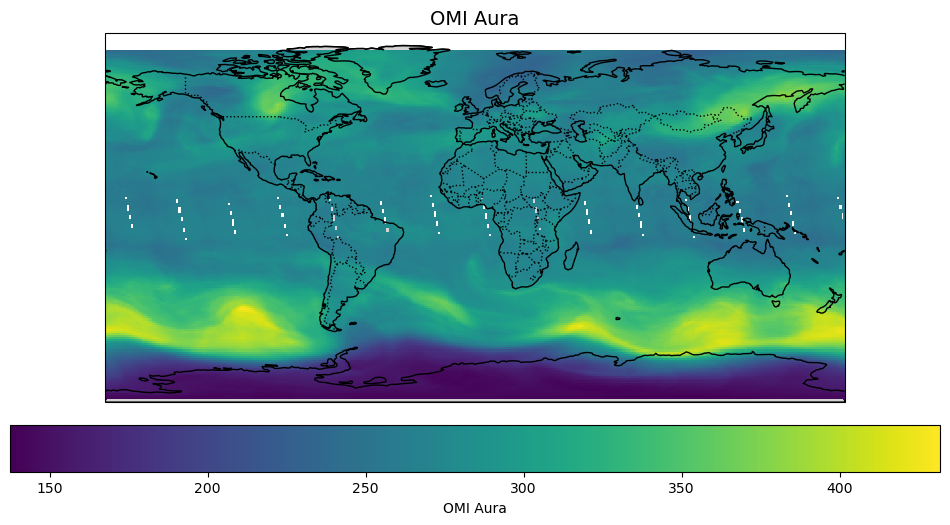

In [18]:
# Plot the ozone levels
plot_ozone_map(ozone_data)

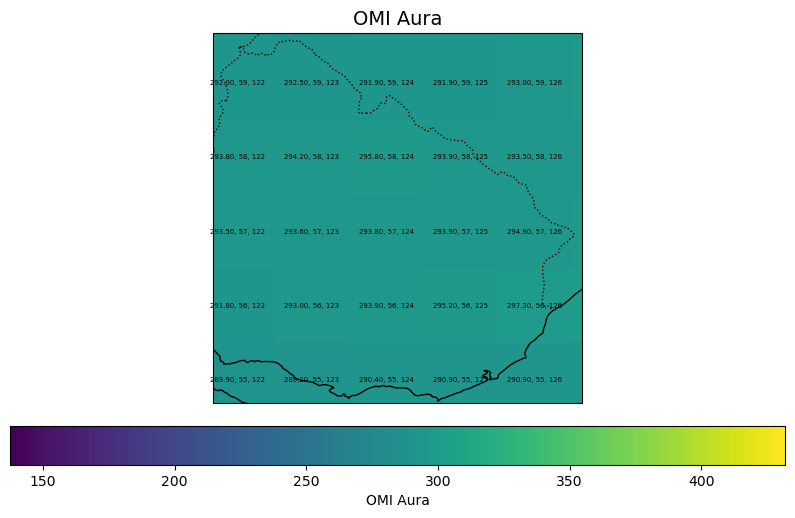

In [19]:
plot_ozone_map_uruguay(ozone_data)

# Uruguay Data Extract

In [9]:
import h5py
import numpy as np

def extract_uruguay_uv_from_file(file_path):
    """Extracts UV index values for Uruguay from a single .he5 file."""
    
    # Define dataset path for UV index
    uv_path = "HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/ColumnAmountO3"

    with h5py.File(file_path, "r") as f:
        # Load UV data
        uv_data = f[uv_path][:]

        # Print dataset shape to verify structure
        print(f"Processing {file_path} - UV Data Shape: {uv_data.shape}")

        # Mask invalid values (-9999 to NaN)
        uv_data = np.where(uv_data < 0, np.nan, uv_data)

        # Extract UV values using correct slicing
        uruguay_uv = uv_data[55:60,122:127]
    
    return uruguay_uv

In [20]:
uruguay_uv_data = {}
folder_path = "OMTO3d"
for filename in os.listdir(folder_path):
    if filename.endswith(".he5"):
        file_path = os.path.join(folder_path, filename)
        

        uruguay_uv_data[filename] = extract_uruguay_uv_from_file(file_path)

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t174138.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1002_v003-2012m0405t174153.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1003_v003-2012m0405t174154.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1004_v003-2012m0405t174148.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1005_v003-2012m0405t174154.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1006_v003-2012m0405t174126.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1007_v003-2012m0405t174115.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1008_v003-2012m0405t174126.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1009_v003-2012m0405t174104.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2004m1010_v003-2012m0405t174124.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0205_v003-2012m0405t180808.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0206_v003-2012m0405t180815.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0207_v003-2012m0405t180837.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0208_v003-2012m0405t180835.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0209_v003-2012m0405t180828.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0210_v003-2012m0405t180834.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0211_v003-2012m0405t180813.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0212_v003-2012m0405t180812.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0213_v003-2012m0405t180811.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0214_v003-2012m0405t180814.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0524_v003-2012m0405t183026.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0525_v003-2012m0405t183012.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0526_v003-2012m0405t183005.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0527_v003-2012m0405t183002.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0528_v003-2012m0405t182932.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0529_v003-2012m0405t183003.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0530_v003-2012m0405t183005.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0531_v003-2012m0405t184051.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0601_v003-2012m0405t184059.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0602_v003-2012m0405t184035.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0917_v003-2012m0405t190213.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0918_v003-2012m0405t190205.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0919_v003-2012m0405t190232.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0920_v003-2012m0405t190254.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0921_v003-2012m0405t190246.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0922_v003-2012m0405t190236.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0923_v003-2012m0405t190249.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0924_v003-2012m0405t190245.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0925_v003-2012m0405t190245.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2005m0926_v003-2012m0405t190154.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0104_v003-2012m0405t195204.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0105_v003-2012m0405t195155.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0106_v003-2012m0405t195214.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0107_v003-2012m0405t195223.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0108_v003-2012m0405t195316.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0109_v003-2012m0405t195236.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0110_v003-2012m0405t195329.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0111_v003-2012m0405t195252.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0112_v003-2012m0405t195326.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0113_v003-2012m0405t195332.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0429_v003-2012m0405t200616.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0430_v003-2012m0405t200531.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0501_v003-2012m0405t200617.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0502_v003-2012m0405t200610.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0503_v003-2012m0405t200637.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0504_v003-2012m0405t200624.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0505_v003-2012m0405t200638.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0506_v003-2012m0405t200636.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0507_v003-2012m0405t200632.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0508_v003-2012m0405t200634.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0807_v003-2012m0405t201702.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0808_v003-2012m0405t201708.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0809_v003-2012m0405t201702.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0810_v003-2012m0405t201652.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0811_v003-2012m0405t202329.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0812_v003-2012m0405t202341.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0813_v003-2012m0405t202348.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0814_v003-2012m0405t202314.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0815_v003-2012m0405t202308.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m0816_v003-2012m0405t202302.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1102_v003-2012m0405t203632.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1103_v003-2012m0405t203620.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1104_v003-2012m0405t203610.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1105_v003-2012m0405t203602.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1106_v003-2012m0405t203626.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1107_v003-2012m0405t203645.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1108_v003-2012m0405t203702.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1109_v003-2012m0405t203656.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1110_v003-2012m0405t203700.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2006m1111_v003-2012m0405t203706.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0129_v003-2012m0405t195320.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0130_v003-2012m0405t195309.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0131_v003-2012m0405t195157.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0201_v003-2012m0405t195200.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0202_v003-2012m0405t195207.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0203_v003-2012m0405t195232.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0204_v003-2012m0405t195328.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0205_v003-2012m0405t195316.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0206_v003-2012m0405t195313.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0207_v003-2012m0405t195300.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0512_v003-2012m0405t200626.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0513_v003-2012m0405t200606.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0514_v003-2012m0405t200624.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0515_v003-2012m0405t200555.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0516_v003-2012m0405t200622.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0517_v003-2012m0405t200630.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0518_v003-2012m0405t200632.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0519_v003-2012m0405t200624.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0520_v003-2012m0405t200604.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0521_v003-2012m0405t200614.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0823_v003-2012m0405t201750.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0824_v003-2012m0405t201726.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0825_v003-2012m0405t201655.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0826_v003-2012m0405t201730.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0827_v003-2012m0405t201748.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0828_v003-2012m0405t201750.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0829_v003-2012m0405t201731.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0830_v003-2012m0405t201740.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0831_v003-2012m0405t201707.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m0901_v003-2012m0405t201737.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1213_v003-2012m0405t203545.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1214_v003-2012m0405t203625.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1215_v003-2012m0405t203633.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1216_v003-2012m0405t203648.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1217_v003-2012m0405t203639.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1218_v003-2012m0405t203635.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1219_v003-2012m0405t203548.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1220_v003-2012m0405t203630.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1221_v003-2012m0405t203636.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2007m1222_v003-2012m0405t203640.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0404_v003-2012m0406t043547.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0405_v003-2012m0406t043538.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0406_v003-2012m0406t043526.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0407_v003-2012m0406t043605.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0408_v003-2012m0406t043605.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0409_v003-2012m0406t043625.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0410_v003-2012m0406t044140.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0411_v003-2012m0406t044131.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0412_v003-2012m0406t044126.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0413_v003-2012m0406t044138.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0724_v003-2012m0406t044838.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0725_v003-2012m0406t045641.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0726_v003-2012m0406t045649.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0727_v003-2012m0406t045641.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0728_v003-2012m0406t045536.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0729_v003-2012m0406t045609.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0730_v003-2012m0406t045614.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0731_v003-2012m0406t045630.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0801_v003-2012m0406t045649.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m0802_v003-2012m0406t045637.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1119_v003-2012m0406t051016.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1120_v003-2012m0406t051014.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1121_v003-2012m0406t051058.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1122_v003-2012m0406t051057.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1123_v003-2012m0406t051054.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1124_v003-2012m0406t051033.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1125_v003-2012m0406t051057.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1126_v003-2012m0406t051058.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1127_v003-2012m0406t051057.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2008m1128_v003-2012m0406t051033.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0314_v003-2012m0406t061102.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0315_v003-2012m0406t061059.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0316_v003-2012m0406t061103.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0317_v003-2012m0406t061106.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0318_v003-2012m0406t061046.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0319_v003-2012m0406t061051.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0320_v003-2012m0406t061052.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0321_v003-2012m0406t061056.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0322_v003-2012m0406t061045.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0323_v003-2012m0406t061050.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0705_v003-2012m0406t063509.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0706_v003-2012m0406t063457.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0707_v003-2012m0406t063443.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0708_v003-2012m0406t063418.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0709_v003-2012m0406t063420.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0710_v003-2012m0406t063412.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0711_v003-2012m0406t063452.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0712_v003-2012m0406t063433.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0713_v003-2012m0406t063452.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m0714_v003-2012m0406t063415.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1026_v003-2012m0406t065845.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1027_v003-2012m0406t065904.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1028_v003-2012m0406t070319.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1029_v003-2012m0406t070323.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1030_v003-2012m0406t070328.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1031_v003-2012m0406t070322.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1101_v003-2012m0406t070320.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1102_v003-2012m0406t070327.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1103_v003-2012m0406t070324.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2009m1104_v003-2012m0406t070329.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0213_v003-2012m0406t094657.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0214_v003-2012m0406t094711.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0215_v003-2012m0406t094725.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0216_v003-2012m0406t094641.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0217_v003-2012m0406t094712.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0218_v003-2012m0406t094735.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0219_v003-2012m0406t094719.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0220_v003-2012m0406t094759.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0221_v003-2012m0406t094726.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0222_v003-2012m0406t094756.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0604_v003-2012m0406t100009.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0605_v003-2012m0406t100005.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0606_v003-2012m0406t095950.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0607_v003-2012m0406t095933.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0608_v003-2012m0406t095932.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0609_v003-2012m0406t100000.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0610_v003-2012m0406t100029.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0611_v003-2012m0406t100032.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0612_v003-2012m0406t100037.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0613_v003-2012m0406t100039.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0926_v003-2012m0406t101517.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0927_v003-2012m0406t101532.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0928_v003-2012m0406t101607.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0929_v003-2012m0406t101558.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m0930_v003-2012m0406t101603.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m1001_v003-2012m0406t101432.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m1002_v003-2012m0406t101415.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m1003_v003-2012m0406t101514.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m1004_v003-2012m0406t101550.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2010m1005_v003-2012m0406t101544.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0111_v003-2012m0406t103838.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0112_v003-2012m0406t103810.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0113_v003-2012m0406t103816.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0114_v003-2012m0406t103729.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0115_v003-2012m0406t103649.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0116_v003-2012m0406t103658.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0117_v003-2012m0406t103805.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0118_v003-2012m0406t103811.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0119_v003-2012m0406t103736.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0120_v003-2012m0406t103612.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0430_v003-2012m0406t105157.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0501_v003-2012m0406t105148.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0502_v003-2012m0406t105145.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0503_v003-2012m0406t105133.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0504_v003-2012m0406t105140.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0505_v003-2012m0406t105123.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0506_v003-2012m0406t105144.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0507_v003-2012m0406t105134.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0508_v003-2012m0406t105131.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0509_v003-2012m0406t105121.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0731_v003-2012m0406t110617.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0801_v003-2012m0406t110611.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0802_v003-2012m0406t110604.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0803_v003-2012m0406t110608.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0804_v003-2012m0406t110602.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0805_v003-2012m0406t110619.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0806_v003-2012m0406t110601.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0807_v003-2012m0406t110627.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0808_v003-2012m0406t110622.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m0809_v003-2012m0406t110633.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1116_v003-2012m0406t112243.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1117_v003-2012m0406t112200.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1118_v003-2012m0406t112304.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1119_v003-2012m0406t112252.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1120_v003-2012m0406t112133.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1121_v003-2012m0406t111956.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1122_v003-2012m0406t111941.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1123_v003-2012m0406t112212.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1124_v003-2012m0406t112141.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2011m1125_v003-2012m0406t112137.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0308_v003-2012m0406t112252.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0309_v003-2012m0406t112244.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0310_v003-2012m0406t112227.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0311_v003-2012m0406t112223.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0312_v003-2012m0406t112123.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0313_v003-2012m0406t112236.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0314_v003-2012m0406t112251.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0315_v003-2012m0406t112250.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0316_v003-2012m0406t112150.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0317_v003-2012m0406t112139.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0629_v003-2012m0830t074853.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0630_v003-2012m0830t074734.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0701_v003-2012m0830t074842.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0702_v003-2012m0830t074703.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0703_v003-2012m0830t074905.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0704_v003-2012m0830t074832.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0705_v003-2012m0830t074927.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0706_v003-2012m0830t074837.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0707_v003-2012m0830t074904.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m0708_v003-2012m0830t074927.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1021_v003-2013m0221t103100.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1022_v003-2013m0221t103132.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1023_v003-2013m0221t103115.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1024_v003-2013m0221t103122.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1025_v003-2013m0221t103115.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1026_v003-2013m0221t103124.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1027_v003-2013m0221t103119.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1028_v003-2013m0221t103122.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1029_v003-2013m0221t103114.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2012m1030_v003-2013m0221t103053.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0214_v003-2013m0216t005147.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0215_v003-2013m0217t014037.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0216_v003-2013m0218t004608.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0217_v003-2013m0219t011714.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0218_v003-2013m0220t020710.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0219_v003-2013m0221t010324.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0220_v003-2013m0222t015612.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0221_v003-2013m0223t005848.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0222_v003-2013m0224t014513.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0223_v003-2013m0225t004647.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0607_v003-2013m0609t025526.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0608_v003-2013m0610t020140.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0609_v003-2013m0611t022809.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0610_v003-2013m0612t030024.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0611_v003-2013m0613t021325.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0612_v003-2013m0614t030007.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0613_v003-2013m0615t020151.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0614_v003-2013m0616t024732.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0615_v003-2013m0617t014241.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0616_v003-2013m0618t021728.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0929_v003-2013m1001t022115.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m0930_v003-2013m1002t031432.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1001_v003-2013m1003t020704.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1002_v003-2013m1004t025651.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1003_v003-2013m1005t020103.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1004_v003-2013m1006t024154.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1005_v003-2013m1007t015626.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1006_v003-2013m1008t021824.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1007_v003-2013m1024t071801.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2013m1008_v003-2013m1024t071816.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0122_v003-2014m0124t020749.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0123_v003-2014m0125t010036.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0124_v003-2014m0126t014318.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0125_v003-2014m0127t005105.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0126_v003-2014m0128t013619.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0127_v003-2014m0129t004231.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0128_v003-2014m0130t011939.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0129_v003-2014m0131t004855.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0130_v003-2014m0201t014316.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0131_v003-2014m0202t015626.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0516_v003-2014m0518t031138.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0517_v003-2014m0519t015703.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0518_v003-2014m0520t022658.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0519_v003-2014m0521t014530.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0520_v003-2014m0522t024549.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0521_v003-2014m0523t034652.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0522_v003-2014m0524t022540.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0523_v003-2014m0525t025235.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0524_v003-2014m0526t023428.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0525_v003-2014m0527t030425.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0907_v003-2014m1124t091920.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0908_v003-2014m1124t091846.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0909_v003-2014m1124t091844.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0910_v003-2014m1124t091936.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0911_v003-2014m1124t091827.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0912_v003-2014m1124t091946.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0913_v003-2014m1124t091847.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0914_v003-2014m1124t091943.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0915_v003-2014m1124t092144.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m0916_v003-2014m1124t092034.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m1229_v003-2014m1231t003529.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m1230_v003-2015m0101t011027.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2014m1231_v003-2015m0102t020541.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0101_v003-2015m0108t113905.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0102_v003-2015m0108t113903.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0103_v003-2015m0108t113553.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0104_v003-2015m0108t113927.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0105_v003-2015m0108t113651.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0106_v003-2015m0108t113817.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0107_v003-2015m0109t002701.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0422_v003-2015m0424t025551.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0423_v003-2015m0425t020640.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0424_v003-2015m0426t025007.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0425_v003-2015m0427t015025.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0426_v003-2015m0428t023710.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0427_v003-2015m0429t015251.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0428_v003-2015m0430t041740.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0429_v003-2015m0501t025941.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0430_v003-2015m0502t020033.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0501_v003-2015m0503t024956.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0815_v003-2015m0817t014915.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0816_v003-2015m0818t024412.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0817_v003-2015m0819t014423.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0818_v003-2015m0820t022522.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0819_v003-2015m0821t012419.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0820_v003-2015m0822t022206.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0821_v003-2015m0823t024902.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0822_v003-2015m0824t023931.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0823_v003-2015m0825t025427.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m0824_v003-2015m0826t013731.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1204_v003-2015m1206t014442.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1205_v003-2015m1207t005131.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1206_v003-2015m1208t145958.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1207_v003-2015m1209t004734.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1208_v003-2015m1210t124538.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1209_v003-2015m1211t021910.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1210_v003-2015m1212t011657.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1211_v003-2015m1213t022415.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1212_v003-2015m1214t005015.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2015m1213_v003-2015m1215t013154.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0320_v003-2016m0322t022416.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0321_v003-2016m0323t013721.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0322_v003-2016m0324t021256.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0323_v003-2016m0325t030252.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0324_v003-2016m0326t122626.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0325_v003-2016m0327t025149.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0326_v003-2016m0328t014722.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0327_v003-2016m0329t024813.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0328_v003-2016m0330t015224.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0329_v003-2016m0331t023401.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0720_v003-2016m0722t044003.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0721_v003-2016m0723t034239.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0722_v003-2016m0724t043623.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0723_v003-2016m0725t024338.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0724_v003-2016m0726t040549.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0725_v003-2016m0727t032826.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0726_v003-2016m0728t041709.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0727_v003-2016m0729t140507.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0728_v003-2016m0802t092633.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m0729_v003-2016m0802t092639.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1111_v003-2016m1114t020359.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1112_v003-2016m1114t130132.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1113_v003-2016m1115t030636.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1114_v003-2016m1116t140159.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1115_v003-2016m1117t022347.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1116_v003-2016m1118t022818.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1117_v003-2016m1119t035133.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1118_v003-2016m1121t072029.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1119_v003-2016m1121t072154.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2016m1120_v003-2016m1122t024318.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0305_v003-2017m0307t031146.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0306_v003-2017m0308t021611.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0307_v003-2017m0309t024659.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0308_v003-2017m0310t130546.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0309_v003-2017m0311t021503.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0310_v003-2017m0312t042624.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0311_v003-2017m0314t035158.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0318_v003-2017m0321t135332.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0319_v003-2017m0321t135346.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0320_v003-2017m0322t031351.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0701_v003-2017m0704t051517.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0702_v003-2017m0704t051518.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0703_v003-2017m0705t020946.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0704_v003-2017m0706t030955.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0705_v003-2017m0707t020922.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0706_v003-2017m0708t031338.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0707_v003-2017m0709t040827.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0708_v003-2017m0710t030634.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0709_v003-2017m0711t030743.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m0710_v003-2017m0712t020632.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1023_v003-2017m1025t020322.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1024_v003-2017m1026t030035.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1025_v003-2017m1027t020301.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1026_v003-2017m1028t030456.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1027_v003-2017m1029t040654.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1028_v003-2017m1030t030633.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1029_v003-2017m1031t030832.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1030_v003-2017m1101t020718.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1031_v003-2017m1102t030347.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2017m1101_v003-2017m1103t020304.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0212_v003-2018m0214t020459.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0213_v003-2018m0215t130311.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0214_v003-2018m0216t020517.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0215_v003-2018m0217t020431.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0216_v003-2018m0218t030443.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0217_v003-2018m0219t020456.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0218_v003-2018m0220t020439.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0219_v003-2018m0221t020800.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0220_v003-2018m0222t020746.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0221_v003-2018m0223t010811.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0604_v003-2019m0822t120127.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0605_v003-2019m0822t120128.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0606_v003-2019m0822t120020.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0607_v003-2019m0822t120135.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0608_v003-2019m0822t120032.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0609_v003-2019m0822t120135.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0610_v003-2019m0822t120030.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0611_v003-2019m0822t120106.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0612_v003-2019m0822t120032.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0613_v003-2019m0822t120128.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0928_v003-2019m0802t075910.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0929_v003-2019m0802t075846.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m0930_v003-2019m0802t075842.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1001_v003-2019m0802t075840.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1002_v003-2019m0802t075843.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1003_v003-2019m0802t075914.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1004_v003-2019m0802t075842.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1005_v003-2019m0802t075936.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1006_v003-2019m0802t075907.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2018m1007_v003-2019m0802t075847.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0106_v003-2019m0108t021502.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0107_v003-2019m0109t010842.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0108_v003-2019m0110t020846.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0109_v003-2019m0111t010906.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0110_v003-2019m0112t031004.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0111_v003-2019m0113t030902.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0112_v003-2019m0114t021033.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0113_v003-2019m0115t025719.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0114_v003-2019m0116t013542.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0115_v003-2019m0117t020942.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0418_v003-2019m0420t031212.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0419_v003-2019m0421t031743.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0420_v003-2019m0422t021310.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0421_v003-2019m0423t042514.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0422_v003-2019m0424t020857.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0423_v003-2019m0425t030702.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0424_v003-2019m0426t040907.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0425_v003-2019m0427t030933.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0426_v003-2019m0428t030910.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0427_v003-2019m0429t021809.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0731_v003-2019m0802t041452.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0801_v003-2019m0803t031434.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0802_v003-2019m0804t031316.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0803_v003-2019m0805t031644.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0804_v003-2019m0806t051757.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0805_v003-2019m0807t190503.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0806_v003-2019m0808t030955.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0807_v003-2019m0809t130310.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0808_v003-2019m0810t031722.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m0809_v003-2019m0811t033719.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1116_v003-2019m1118t011227.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1117_v003-2019m1119t120303.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1118_v003-2019m1120t031444.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1119_v003-2019m1121t021239.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1120_v003-2019m1122t021516.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1121_v003-2019m1123t021814.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1122_v003-2019m1124t022345.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1123_v003-2019m1125t022157.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1124_v003-2019m1126t022554.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2019m1125_v003-2019m1127t011515.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0225_v003-2020m0227t021638.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0226_v003-2020m0228t021838.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0227_v003-2020m0229t021605.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0228_v003-2020m0301t021638.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0229_v003-2020m0302t011545.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0301_v003-2020m0303t015408.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0302_v003-2020m0304t032727.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0303_v003-2020m0305t141315.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0304_v003-2020m0306t022850.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0305_v003-2020m0307t011800.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0608_v003-2020m0610t031717.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0609_v003-2020m0611t022048.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0610_v003-2020m0612t031428.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0611_v003-2020m0613t021122.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0612_v003-2020m0614t031843.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0613_v003-2020m0615t042055.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0614_v003-2020m0616t031828.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0615_v003-2020m0617t031927.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0616_v003-2020m0618t023423.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0617_v003-2020m0619t031307.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0918_v003-2020m0920t140903.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0919_v003-2020m0921t044821.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0920_v003-2020m0922t012515.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0921_v003-2020m0923t031230.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0922_v003-2020m0924t021529.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0923_v003-2020m0925t031453.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0924_v003-2020m0926t024008.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0925_v003-2020m0927t024638.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0926_v003-2020m0928t033613.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m0927_v003-2020m0929t022649.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m1228_v003-2020m1230t012138.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m1229_v003-2020m1231t012059.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m1230_v003-2021m0104t135726.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2020m1231_v003-2021m0104t140414.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0101_v003-2021m0104t135729.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0102_v003-2021m0104t135810.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0103_v003-2021m0105t095835.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0104_v003-2021m0106t023608.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0105_v003-2021m0107t012151.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0106_v003-2021m0108t025526.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0408_v003-2021m0410t033332.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0409_v003-2021m0411t023848.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0410_v003-2021m0412t034032.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0411_v003-2021m0413t022820.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0412_v003-2021m0414t031623.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0413_v003-2021m0415t033254.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0414_v003-2021m0416t033008.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0415_v003-2021m0417t035237.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0416_v003-2021m0418t024520.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0417_v003-2021m0419t034105.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0720_v003-2022m0113t225414.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0721_v003-2022m0113t225405.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0722_v003-2022m0113t225418.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0723_v003-2022m0113t225414.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0724_v003-2022m0113t225416.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0725_v003-2022m0113t225409.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0726_v003-2022m0113t225412.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0727_v003-2022m0113t225412.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0728_v003-2022m0113t225414.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m0729_v003-2022m0113t225428.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1031_v003-2022m0114t000111.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1101_v003-2022m0114t000049.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1102_v003-2022m0114t000046.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1103_v003-2022m0114t000052.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1104_v003-2022m0114t000042.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1105_v003-2022m0114t000110.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1106_v003-2022m0114t000055.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1107_v003-2022m0114t000054.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1108_v003-2022m0114t000049.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2021m1109_v003-2022m0114t000042.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0210_v003-2022m0212t022120.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0211_v003-2022m0213t032238.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0212_v003-2022m0214t021829.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0213_v003-2022m0215t023439.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0214_v003-2022m0216t024514.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0215_v003-2022m0217t021849.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0216_v003-2022m0218t011629.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0217_v003-2022m0219t021758.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0218_v003-2022m0220t011604.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0219_v003-2022m0221t022031.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0522_v003-2022m0524t042623.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0523_v003-2022m0525t015724.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0524_v003-2022m0526t031524.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0525_v003-2022m0527t022753.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0526_v003-2022m0528t032723.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0527_v003-2022m0529t033627.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0528_v003-2022m0530t031619.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0529_v003-2022m0531t031213.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0530_v003-2022m0601t022021.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0531_v003-2022m0602t033647.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0903_v003-2022m0905t022344.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0904_v003-2022m0906t032227.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0905_v003-2022m0907t021350.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0906_v003-2022m0908t031320.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0907_v003-2022m0909t041806.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0908_v003-2022m0910t033555.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0909_v003-2022m0911t032156.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0910_v003-2022m0912t023311.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0911_v003-2022m0913t035119.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m0912_v003-2022m0914t023302.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1218_v003-2023m0309t170126.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1219_v003-2023m0309t170116.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1220_v003-2023m0309t170127.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1221_v003-2023m0309t170138.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1222_v003-2023m0309t170154.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1223_v003-2023m0309t170132.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1224_v003-2023m0309t170156.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1225_v003-2023m0309t170145.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1226_v003-2023m0309t170147.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2022m1227_v003-2023m0309t170142.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0329_v003-2023m0331t043108.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0330_v003-2023m0401t021911.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0331_v003-2023m0402t032935.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0401_v003-2023m0403t022337.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0402_v003-2023m0404t031333.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0403_v003-2023m0405t041438.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0404_v003-2023m0406t071810.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0405_v003-2023m0407t041230.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0406_v003-2023m0408t031306.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0407_v003-2023m0409t031121.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0710_v003-2023m0712t030009.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0711_v003-2023m0713t041651.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0712_v003-2023m0714t031850.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0713_v003-2023m0715t031412.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0714_v003-2023m0716t031123.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0715_v003-2023m0717t031109.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0716_v003-2023m0718t032740.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0717_v003-2023m0719t040503.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0718_v003-2023m0720t031352.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m0719_v003-2023m0802t213223.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1017_v003-2023m1019t021506.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1018_v003-2023m1020t160740.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1019_v003-2023m1021t035105.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1020_v003-2023m1022t061243.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1021_v003-2023m1023t040753.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1022_v003-2023m1024t031316.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1023_v003-2023m1025t031656.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1024_v003-2023m1026t021242.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1025_v003-2023m1027t033419.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2023m1026_v003-2023m1028t030648.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0131_v003-2024m0203t022408.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0201_v003-2024m0204t022847.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0202_v003-2024m0204t022839.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0203_v003-2024m0205t021452.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0204_v003-2024m0207t031214.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0205_v003-2024m0207t031228.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0206_v003-2024m0208t021458.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0207_v003-2024m0209t022202.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0208_v003-2024m0210t011131.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0209_v003-2024m0212t011203.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0514_v003-2024m0516t032618.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0515_v003-2024m0517t023143.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0516_v003-2024m0519t022118.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0517_v003-2024m0520t032544.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0518_v003-2024m0521t012551.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0519_v003-2024m0521t021451.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0520_v003-2024m0522t021452.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0521_v003-2024m0523t030631.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0522_v003-2024m0524t031315.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0523_v003-2024m0525t040138.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0820_v003-2024m0822t020146.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0821_v003-2024m0823t022723.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0822_v003-2024m0824t012041.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0823_v003-2024m0825t022405.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0824_v003-2024m0826t022745.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0825_v003-2024m0827t022803.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0826_v003-2024m0828t022701.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0827_v003-2024m0829t094609.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0828_v003-2024m0830t025500.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m0829_v003-2024m0901t032527.he5 - UV Data Shape: (

Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1127_v003-2024m1129t002522.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1128_v003-2024m1130t012252.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1129_v003-2024m1201t002750.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1130_v003-2024m1202t002945.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1201_v003-2024m1203t004356.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1202_v003-2024m1204t002850.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1203_v003-2024m1205t015918.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1204_v003-2024m1206t010815.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1205_v003-2024m1207t014427.he5 - UV Data Shape: (180, 360)
Processing OMTO3d\OMI-Aura_L3-OMTO3d_2024m1206_v003-2024m1208t005349.he5 - UV Data Shape: (

In [21]:
x = []
X = []

for value in uruguay_uv_data.keys():
    s_i = 55
    for i in range(uruguay_uv_data[value].shape[0]):
        s_j = 122
        for j in range(uruguay_uv_data[value].shape[1]):
            x = []
            x.append(value)
            x.append(f"{value[19:23]}-{value[24:26]}-{value[26:28]}")
            x.append(s_i)
            x.append(s_j)
            x.append(uruguay_uv_data[value][i,j])
            
            X.append(x)
            s_j = s_j + 1
        s_i = s_i + 1
        
X = np.asarray(X)

In [24]:
pd.DataFrame(X,columns = ['File_Name','Date','Latitude', 'Longitude', 'UV_Index'])

,File_Name,Date,Latitude,Longitude,UV_Index
0,OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t17...,2004-10-01,55,122,289.9
1,OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t17...,2004-10-01,55,123,289.2
2,OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t17...,2004-10-01,55,124,290.4
3,OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t17...,2004-10-01,55,125,290.9
4,OMI-Aura_L3-OMTO3d_2004m1001_v003-2012m0405t17...,2004-10-01,55,126,290.9
...,...,...,...,...,...
184895,OMI-Aura_L3-OMTO3d_2025m0207_v003-2025m0209t01...,2025-02-07,59,122,nan
184896,OMI-Aura_L3-OMTO3d_2025m0207_v003-2025m0209t01...,2025-02-07,59,123,nan
184897,OMI-Aura_L3-OMTO3d_2025m0207_v003-2025m0209t01...,2025-02-07,59,124,nan
184898,OMI-Aura_L3-OMTO3d_2025m0207_v003-2025m0209t01...,2025-02-07,59,125,nan


In [25]:
pd.DataFrame(X,columns = ['File_Name','Date','Latitude', 'Longitude', 'Ozone']).to_excel('OMTO3d/OMTO3d data.xlsx')